In [1]:
import ratterdam_CoreDataStructures as Core
import ratterdam_ParseBehavior as Parse
import numpy as np
from scipy.stats import sem
import utility_fx as util
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import ratterdam_Defaults as Def
import ratterdam_visBasic as Vis
import RateMapClass_William_20190308 as RateMapClass
import williamDefaults as wmDef
from matplotlib.backends.backend_pdf import PdfPages
import more_itertools, itertools
from sklearn.metrics import auc
import alphashape
from descartes import PolygonPatch
from scipy.interpolate import splrep, splev

In [2]:
%qtconsole --style native
%matplotlib qt5

In [3]:
def loadRepeatingUnit(df, clustName):
    """take a path to a data dir
    load spikes and position into two np arrays
    spikes is (n,1) and pos is typical (3,n) cols of ts,x,y
    use cameraOrientationInfo.txt to flip axes if needed
    use sessionEpochInfo.txt, specific for open Ratterdam exp
    to get session ts and clip spikes/pos"""
    
    with open(df+"sessionEpochInfo.txt","r") as f:
        lines = f.readlines()
    start, end = int(lines[0].split(',')[0]), int(lines[0].split(',')[1])
    pos = util.read_pos(df)
    ts = np.asarray(sorted(list(pos.keys())))
    posx, posy = Parse.adjustPosCamera(df, pos, ts)
    position = np.column_stack((ts, posx, posy))
    position = position[(position[:,0]>=start) & (position[:,0]<=end)]
    clust = np.asarray(util.read_clust(df+clustName))
    clust = clust[(clust >= start) & (clust <= end)]
    spikexy = util.getPosFromTs(clust,position)
    spikes = np.column_stack((clust,spikexy))
    
    return position, spikes

In [301]:
class Unit():
    """
    Wrapper class because rep field ID algorithm looks
    for instance.spikes and instance.position
    """
    
    def __init__(self, s, p):
        self.spikes = s
        self.position = p
        self.fields = []
        self.visits = [] # nested list. each list is a subfield and values are themselves lists of points in visit
        self.perimeters = []
        self.colors = cnames
        self.smoothing = 2
        self.repUnit = RateMapClass.RateMap(self)
        self.alphaHullFactor = 1
        self.alpha = 0
        self.findFields()
        
    def PolyArea(self,x,y):
        """
        Found at https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
        """
        return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
        
    def findFields(self):
        self.fields = []
        self.visits = []
        for i,pf in enumerate(self.repUnit.PF[:]):
            self.visits.append([])
            #create boundary using alphahull alg which allows for concave hulls but does not work all that well as is
#             alpha = self.alphaHullFactor*alphashape.optimizealpha(list(zip(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)))
#             hull = alphashape.alphashape(list(zip(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)),alpha)
#             hxy = hull.exterior.coords.xy
#             contour = path.Path(list(zip(hxy[0],hxy[1])))

            #create boundary using convex hull
            points = np.asarray(list(zip(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)))
            hull = ConvexHull(points)
            vertices = np.append(hull.vertices, hull.vertices[0]) # add the first point to close the contour
            contour = path.Path(points[vertices])

            PinC = self.position[contour.contains_points(self.position[:,1:])]
            posVisits = getVisits(PinC[:,0])
            self.visits[-1].append(posVisits)
            field_FR = []
            field_TS = [] # take middle ts 
            for visit in posVisits:
                spk = self.spikes[np.logical_and(self.spikes[:,0] > visit[0], self.spikes[:,0] < visit[-1])]
                vdur = (visit[-1]-visit[0])/1e6 # do this instead of just multiplying number samples by fr because any lost frames from, e.g. occlusions will introduce a discrepancy
                field_FR.append(spk.shape[0]/vdur)
                field_TS.append(((visit[0]-self.position[0,0])/1e6)/60)
                
            field_FR = util.weird_smooth(np.asarray(field_FR), self.smoothing)
            
            totalRate = sum(field_FR)
            area = self.PolyArea(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)
            print(totalRate/area)
            if True:
                self.fields.append(np.column_stack((field_TS, field_FR)))
                self.perimeters.append(points[vertices])

In [295]:
def getVisits(data, maxgap=2*1e6):
    """
    """
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups

In [6]:
cnames = ['black', 'blue', 'green', 'red', 'brown', 'purple', 'cornflowerblue', 'orchid', 'darkcyan', 'midnightblue', 'saddlebrown', 'darkviolet', 'seagreen', 'indianred', 'goldenrod', 'orange', 'olive']
binWidth = wmDef.binWidth
from matplotlib import path
cmap = util.makeCustomColormap()

In [162]:
def plotRoutine_RepPF_TempDyn(smoothing=0, nf=99, time='time', save=False):
    """
    Plotting routine using unit and ratemapclass classes in local namespace
    Create a ratemap of fields with detected fields outlined
    Below, plot visit FR over time for each field, color coded to match
    
    """
    fig, ax = plt.subplots(2,1, figsize=(10,14))
    
    fig.axes[0].imshow(unit.repUnit.rateMap2D, origin='lower', aspect='auto', interpolation='None', 
                       cmap=cmap, vmax=np.nanpercentile(unit.repUnit.rateMap2D, 98),
                extent=[wmDef.xedges[0], wmDef.xedges[-1], wmDef.yedges[0], wmDef.yedges[-1]])
    fig.axes[0].set_title(f"{clust}, cutoff = {round(np.nanpercentile(unit.repUnit.rateMap2D, 98),2)}Hz", fontsize=20)
    fig.axes[0].axis('equal')
    fig.axes[0].set_ylim([0,480])
    fig.axes[0].set_xlim([0, 640])
    fig.axes[0].set_xticks([])
    fig.axes[0].set_yticks([])
    fig.axes[0].spines['top'].set_visible(False)
    fig.axes[0].spines['right'].set_visible(False)
    fig.axes[0].spines['bottom'].set_visible(False)
    fig.axes[0].spines['left'].set_visible(False)

    #option to not visualize garbage fields. 99 is an 'infinity' value as no cell will have 99 fields. 
    if nf == 99:
        end = len(unit.fields)
    else:
        end = nf
        
    for i, field in enumerate(unit.fields[:end]):
        f = util.weird_smooth(field[:,1],smoothing)
        
        if time == 'time':
            xval = field[:,0]
        elif time  == 'visit' or time == 'visits':
            xval = range(field.shape[0])
        
        fig.axes[1].plot(xval, f, color=unit.colors[i], marker='.',alpha=0.8)
        fig.axes[0].plot(unit.perimeters[i][:,0], unit.perimeters[i][:,1],color=unit.colors[i])
        fig.axes[1].tick_params(axis='y', labelsize=14)
        fig.axes[1].tick_params(axis='x', labelsize=14)
        fig.axes[1].set_xlabel(f"Time in session ({(lambda x: 'min' if x == 'time' else 'visits')(time)})", fontsize=24)
        fig.axes[1].set_ylabel("Firing Rate (Hz, smoothed)", fontsize=24)
        fig.axes[1].spines['right'].set_visible(False)
        fig.axes[1].spines['top'].set_visible(False)
        fig.axes[1].set_title(f"gaussian smoothing sigma = {smoothing+unit.smoothing}", fontsize=12)
    
    if save:
        clustname = clust.replace("\\","_")
        plt.savefig(fname=savepath+clustname+".png", format='png')
        plt.close()
    

In [338]:
# avgRates, iqrs = [], []
# for i,pf in enumerate(repUnit.PF[:6]):
#     contour = path.Path(list(zip(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)))
#     PinC = unit.position[contour.contains_points(unit.position[:,1:])]
#     posVisits = getVisits(PinC[:,0])
#     field_FR = []
#     field_TS = [] # take middle ts 
#     for visit in posVisits:
#         spk = unit.spikes[np.logical_and(unit.spikes[:,0] > visit[0], unit.spikes[:,0] < visit[-1])]
#         field_FR.append((spk.shape[0]/len(visit))*30)
#         field_TS.append(((visit[0]-unit.position[0,0])/1e6)/60)
#     avgRates.append(np.mean(field_FR))
#     iqrs.append(scipy.stats.iqr(field_FR))
    
#     for i in range(len(avgRates)):
#         avgRates[i] = avgRates[i]/max(avgRates)
#         iqrs[i] = iqrs[i]/avgRates[i]

In [194]:
# Take each cell in a day and generate a plot with rate map overlaid w detected field edges
# and field dynamics (Fr over time) below
rat = "R808"
day = "D6"
savepath = f'E:\\Ratterdam\\{rat}\\ratterdam_plots\\{day}\\'
df = f'E:\Ratterdam\\{rat}\\{rat}_RatterdamOpen_{day}\\'
clustList = util.getClustList(df)
for clust in clustList:
    p, s = loadRepeatingUnit(df, clust)
    rm = util.makeRM(s,p)
    if np.nanpercentile(rm, 95) > 1.:
        print(clust)
        unit = Unit(s,p)
        plotRoutine_RepPF_TempDyn(0,save=True)
    else:
        print(f"{clust} did not pass Fr thresh")

C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:498: RuntimeWarning: divide by zero encountered in reciprocal
  n = (hs*np.reciprocal(ho))*30
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:498: RuntimeWarning: invalid value encountered in multiply
  n = (hs*np.reciprocal(ho))*30
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:325: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


TT12\cl-maze1.1 did not pass Fr thresh
TT12\cl-maze1.10


C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\RateMapClass_William_20190308.py:210: RuntimeWarning: invalid value encountered in greater_equal
  aboveThreshold = np.where(rateMap >= max(fieldThreshold,0), True, False)


TT12\cl-maze1.2
TT12\cl-maze1.3
TT12\cl-maze1.4 did not pass Fr thresh
TT12\cl-maze1.5 did not pass Fr thresh
TT12\cl-maze1.7
TT12\cl-maze1.8
TT12\cl-maze1.9 did not pass Fr thresh
TT15\cl-maze1.1
TT15\cl-maze1.2
TT15\cl-maze1.3
TT15\cl-maze1.4 did not pass Fr thresh
TT15\cl-maze1.5


# Quantifying temporal dynamics of repeating subfields
#### Single-cell analysis of which cells, if any, have subfields that exhibit more temporal fluctuations than
#### would be expected by chance

In [328]:
rat = "R808"
day = "D6"
savepath = f'E:\\Ratterdam\\{rat}\\ratterdam_plots\\{day}\\'
df = f'E:\Ratterdam\\{rat}\\{rat}_RatterdamOpen_{day}\\'
clust = "TT15\\cl-maze1.1"
p, s = loadRepeatingUnit(df, clust)
unit = Unit(s,p)
repUnit = RateMapClass.RateMap(unit)

C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\RateMapClass_William_20190308.py:210: RuntimeWarning: invalid value encountered in greater_equal
  aboveThreshold = np.where(rateMap >= max(fieldThreshold,0), True, False)


In [329]:
smoothing = 0
for i,pf in enumerate(repUnit.PF[:]):
    contour = path.Path(list(zip(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)))
    PinC = unit.position[contour.contains_points(unit.position[:,1:])]
    posVisits = getVisits(PinC[:,0])
    field_FR = []
    field_TS = [] # take middle ts 
    for visit in posVisits:
        spk = unit.spikes[np.logical_and(unit.spikes[:,0] > visit[0], unit.spikes[:,0] < visit[-1])]
        field_FR.append((spk.shape[0]/len(visit))*30)
        field_TS.append(((visit[0]-unit.position[0,0])/1e6)/60)
    field_FR = util.weird_smooth(np.asarray(field_FR), smoothing)

    unit.fields.append(np.column_stack((field_TS, field_FR)))

In [8]:
# set parameters and choose which field to analyze
def find_rateRegime_shift(field, winSz=5, look_ahead=5, thresh=2):
    """
    Take a sliding window of size winSz (always steps by 1).
    Look for a rate change in the next element (i.e. first element of next window_n+1)
    that is excessive of mean(window_n) +/- thresh*std(window_n). If so see if it persists for look_ahead num of visits
    Remove duplicates (i.e. as you slide the window by 1 unit and there's a change youll
    catch it multiple times) by having the changes by at least a window length apart.
    Return the indices of the change locations
    """
    rate_changes = []

    for i in range(len(field)):

        window = field[i:i+winSz] # sliding window. serves as baseline rate to compare future putative rate changes to
        if i < (len(field)-(winSz+look_ahead)):

            #straightforward - twosided threshold +/- 2*std of the reference window
            threshUp, threshDown = np.mean(window) + thresh*np.std(window), np.mean(window) - thresh*np.std(window)
            if threshDown < 0:
                threshDown = 0 # can't have a negative fr 

            if (field[i+winSz+1][1] > threshUp) or (field[i+winSz+1][1] < threshDown):

                # keep track here of whether candidate visit is above or below thresh. B/c youre
                # looking for this pattern to persist so need to know direction
                if field[i+winSz+1][1] > threshUp:
                    compfx = np.greater
                    thresh = threshUp
                elif field[i+winSz+1][1] < threshDown:
                    compfx = np.less
                    thresh = threshDown

                # walk ahead a certain number of trials and see if the threshold crossing persists
                for j in range(look_ahead):
                    if ~compfx(field[i+winSz+1+j][1], thresh): # if it doesnt, break out
                        break
                if j == look_ahead-1: # meaning you got to the end all visits were more extreme than thresh
                    if rate_changes != []:
                        # basically because we're using a sliding window, a rate change event 
                        # can be counted multiple times as the window slides. so make sure
                        # two rate change events are spaced by at least the winSz meaning youre not doublecounting
                        if np.abs(rate_changes[-1]-i) < winSz:
                            pass
                        else:
                            rate_changes.append(i)
                    elif rate_changes == []:
                        rate_changes.append(i)
    return rate_changes

In [311]:
# Generate a null distibution of rate vectors and see how many have a persistant threshold crossing
# w.r.t dynamic rate change
field = unit.fields[0]
numShuffles = 1000
nullCrossings =[]
real_crossings = find_rateRegime_shift(field)
for r in range(numShuffles):
    shuffData = np.random.permutation(field)
    rate_changes = find_rateRegime_shift(shuffData)
    nullCrossings.append(len(rate_changes))
(len([i for i in nullCrossings if i>0])/numShuffles)*100

1.5

### Analysis of dynamic rate changes improving separability/distance between field rate regimes

In [314]:
with open(df+"sessionEpochInfo.txt","r") as f:
        lines = f.readlines()
startSession_us, endSession_us = int(lines[0].split(',')[0]), int(lines[0].split(',')[1])

startSession = 0 # because were dealing with relative mins in session, its by def 0
endSession = ((endSession_us-startSession_us)/1e6)/60

In [311]:
def compute_max_fieldRateDistances(unit, shuffle=False):

    winSz = 5 # in minutes
    winoffset = 1 # amount in minutes by which to shift sliding window between iterations
    #combinations will be a list of tuples. Each tuple is a pair of unit.fields
    # so structure is [(array(ts,r), array(ts,r)), (''), ...]
    if shuffle == False:
        combinations = list(itertools.combinations(unit.fields,2))
        
    #if shuffle, then shuffle visits to each field while maintaining field identity and proceed
    elif shuffle == True:
        shuffled_fields = []
        for field in unit.fields:
            sf = np.random.permutation(field[:,0])
            shuffled_fields.append(np.column_stack((sf,field[:,1])))
        combinations = list(itertools.combinations(shuffled_fields,2))
        
        
    field_distances = []
    for pair in combinations:
        field_distances.append([])
        fieldA, fieldB = pair
        #get the earliest and latest recorded timestamps for each field
        reachedEnd = False
        winStart = startSession
        while not reachedEnd:
            start, stop = winStart, winStart + winSz
            winA = fieldA[(fieldA[:,0]>start)&(fieldA[:,0]<stop)]
            winB = fieldB[(fieldB[:,0]>start)&(fieldB[:,0]<stop)]
            #key computation: taking  'distance' of windowed field rate vector
            #if either window does not contain any visits, return nan as it's not a real comparison
            if winA.shape[0] == 0 or winB.shape[0] == 0:
                dist = np.nan
            else:
                dist = np.abs(np.mean(winA[:,1])-np.mean(winB[:,1]))
            field_distances[-1].append(dist)
            winStart += winoffset
            if winStart >= endSession:
                reachedEnd = True
    field_distances = np.asarray(field_distances)
    maxdistances = field_distances.max(axis=0)
    return field_distances, maxdistances

In [315]:
fd,maxd = compute_max_fieldRateDistances(unit, shuffle=False)
shuffmaxes = []
for i in range(5000):
    _,shuffmax = compute_max_fieldRateDistances(unit, shuffle=True)
    shuffmaxes.append(shuffmax)
shuffmaxes = np.asarray(shuffmaxes)

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [316]:
plt.figure()
plt.plot(maxd,'r')
pct95 = np.percentile(shuffmaxes,95,axis=0)
plt.plot(pct95,'b--')

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [26]:
## Save routine for the following f.ea. cell
# - rate map and field dynamics over time (previously saved by itself)
# - f.ea. field plot field over time 95% CI for epoch crossing
# - composite max rate diff trace w 95% CI
# - heatmap of all pairwise field comparisons 

rat = "R859"
day = "D2"
smooth = 1
numShuffles = 1000
nCols = 2 # for subplots, fix num cols and add rows as needed
savepath = f'E:\\Ratterdam\\{rat}\\ratterdam_plots\\{day}\\'
df = f'E:\Ratterdam\\{rat}\\{rat}_RatterdamOpen_{day}\\'

with open(df+"sessionEpochInfo.txt","r") as f:
        lines = f.readlines()
startSession_us, endSession_us = int(lines[0].split(',')[0]), int(lines[0].split(',')[1])

startSession = 0 # because were dealing with relative mins in session, its by def 0
endSession = ((endSession_us-startSession_us)/1e6)/60


clustList = util.getClustList(df)
for clust in clustList[48:]:
    p, s = loadRepeatingUnit(df, clust)
    rm = util.makeRM(s,p)
    if np.nanpercentile(rm, 95) > 1.:
        print(clust)
        unit = Unit(s,p)
        repUnit = RateMapClass.RateMap(unit)
        
        # add field rates to unit object. this procedure is done in plotRoutine_RepPF_TempDyn
        # but it doesn't save it to unit obj and i want to keep them separate so do it again here w save
        for i,pf in enumerate(repUnit.PF[:]):
            unit.colors.append(cnames[i])
            contour = path.Path(list(zip(pf.perimeter[1]*binWidth+binWidth/2, pf.perimeter[0]*binWidth+binWidth/2)))
            PinC = unit.position[contour.contains_points(unit.position[:,1:])]
            posVisits = getVisits(PinC[:,0])
            field_FR = []
            field_TS = [] # take middle ts 
            for visit in posVisits:
                spk = unit.spikes[np.logical_and(unit.spikes[:,0] > visit[0], unit.spikes[:,0] < visit[-1])]
                field_FR.append((spk.shape[0]/len(visit))*30)
                field_TS.append(((visit[0]-unit.position[0,0])/1e6)/60)
            field_FR = util.weird_smooth(np.asarray(field_FR), smooth)
            unit.fields.append(np.column_stack((field_TS, field_FR)))
        
        numFields = len(unit.fields) # use this to design good subplot dims
        if numFields > 0:
        
            clustname = clust.replace("\\","_")
            with PdfPages(savepath+f"{clustname}_FieldDynamicsAnalysis.pdf") as pdf:

                # 1 - cell ratemap and fields over time
                plotRoutine_RepPF_TempDyn(smooth,save=False)
                pdf.savefig()
                plt.close()
                print("Ratemap and field dynamics saved")

                # 2 - each field, plot it and 95% CI (i think it still should be onesided because although
                # rate deviations over time could be up or down, you abstract and call it a deviation
                # then are comparing the abundance of these to that under the null)
                nRows = int(np.ceil(numFields/nCols))
                fig, ax = plt.subplots(nRows, nCols, figsize=(15,10))
                for i,field in enumerate(unit.fields):
                    nullCrossNums = []
                    real_crossings = find_rateRegime_shift(field)
                    for r in range(numShuffles):
                        shuffData = np.random.permutation(field)
                        rate_changes = find_rateRegime_shift(shuffData)
                        nullCrossNums.append(len(rate_changes))

                    fig.axes[i].plot(field[:,1],color=unit.colors[i])
                    if real_crossings is not []:
                        # find a pvalue(?) by getting percentage of nulls that pass the criteria
                        # if that's less than 5% then it passes and color it red to signify this
                        p = (len([i for i in nullCrossNums if i>0])/numShuffles)*100
                        if p < 5:
                            color = 'r'
                        elif p >= 5:
                            color = 'k'
                        for crossing in real_crossings:
                            fig.axes[i].vlines(crossing, 0, max(field[:,1]), color=color)
                fig.axes[0].set_xlabel("Time (min)")
                fig.axes[0].set_ylabel("Firing Rate (Hz)")
                plt.suptitle("Detected Fields, w. Marked +/-2*std thresh crossings (red==95% sig)",fontsize=16)
                pdf.savefig()
                plt.close()
                print("Field Rate Modulation Analysis Saved")

                # 3/4 - composite, maximum windowed pairwise rate diffs. And a heatmap of all the pairs
                if len(unit.fields)>1:
                    fig, ax = plt.subplots(2,1, figsize=(10,10))
                    fd,maxd = compute_max_fieldRateDistances(unit, shuffle=False)
                    shuffmaxes = []
                    for i in range(numShuffles):
                        _,shuffmax = compute_max_fieldRateDistances(unit, shuffle=True)
                        shuffmaxes.append(shuffmax)
                    shuffmaxes = np.asarray(shuffmaxes)
                    fig.axes[0].plot(maxd,'r')
                    pct95 = np.percentile(shuffmaxes,95,axis=0)
                    fig.axes[0].plot(pct95,'k--')
                    fig.axes[0].set_xlabel("Time (rel)")
                    fig.axes[0].set_ylabel("Composite Maximum FR Diff, Windowed",fontsize=12)

                    fig.axes[1].imshow(fd, aspect='auto', interpolation='None',cmap=cmap)
                    fig.axes[1].set_xlabel("Time (rel)")
                    fig.axes[1].set_ylabel("Pairwise Field Rate Comparisons",fontsize=12)

                    plt.suptitle("Pairwise Subfield Rate Diffs, Unsigned + Windowed",fontsize=16)
                    pdf.savefig()
                    plt.close()
                    print("Pairwise Field Comparison Analysis Saved")
                           
    else:
        print(f"{clust} did not pass Fr thresh")


C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:498: RuntimeWarning: divide by zero encountered in reciprocal
  n = (hs*np.reciprocal(ho))*30
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:498: RuntimeWarning: invalid value encountered in multiply
  n = (hs*np.reciprocal(ho))*30
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:325: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\RateMapClass_William_20190308.py:210: RuntimeWarning: invalid value encountered in greater_equal
  aboveThreshold = np.where(rateMap >= max(fieldThreshold,0), True, False)


TT7_0001\cl-maze1.3
TT7_0001\cl-maze1.4
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved


C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Pairwise Field Comparison Analysis Saved
TT7_0001\cl-maze1.5
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT7_0001\cl-maze1.6
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT7_0001\cl-maze1.7
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT7_0001\cl-maze1.8
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT8\cl-maze1.1
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT8\cl-maze1.2
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT8\cl-maze1.3
Ratemap and field dynamics saved
Field Rate Modulation Analysis Saved
Pairwise Field Comparison Analysis Saved
TT8\cl-maze1.4 did not pass Fr thresh
TT8\cl-maze1.5
Rate

### Field Detection Dynamics - Using Inflection points and thresholding those epochs

In [739]:
def findInflections(field):
    """
    Find all inflection pts of the input 1d (n,1) array
    array ([x,y]...)
    I.e. where there is a change in 2nd deriv
    """
    signdelta = np.sign(np.diff(field, axis=0))
    idx = np.where(np.diff(signdelta,axis=0)!=0)[0] # by convention sign returns +/-1 so if you think about it two diff values will be +/2 and two same values in a row will be zero
    idx = idx + 1 # the above catches the point right before the inflection
    idx = np.hstack((0,idx, field.shape[0]-1))
    return idx

In [867]:
def length_filter(idx,data,thresh=2):
    """Filter the visits that have been flagged as rate change
    epoch boundaries by whether the epoch is long enough. Ie. if
    there are at least thresh visits *between* the successive epoch
    bounds"""
    
    #unpacking below: you diff your input idx list and look for diffs that are big enough
    # bc diffing the last element is impossible only get original idx vals up to not incl the end
    passidx = idx[:-1][np.diff(idx,axis=0)>=thresh+1]
    passidx = np.hstack((passidx, data.shape[0]-1)) #add this back on
    passidx = passidx[:,np.newaxis]
    return passidx

In [846]:
def magnitude_filter(idx,data, thresh=0.20):
    """
    Filter potential epochs according to whether or not
    the beginning to end difference (idx[n],idx[n+1]) exceeds
    thresh % of the range of all the data. Data is 1d (n,1) array
    """
    passidx = np.empty((0,1),dtype=np.int)
    for i in range(0,idx.shape[0]-1):
        start, stop = data[idx[i]], data[idx[i+1]]
        pctRange = abs(start-stop)/(data.max()-data.min())
        if pctRange >= thresh:
            passidx = np.vstack((passidx, i))
    passidx = np.vstack((idx[passidx], data.shape[0]-1)) #add this back on 
    return passidx

### Field detection dynamics - using filters to smooth curve, and a MSE CV method to determine appropriate smoothing

#### Methods of preprocessing

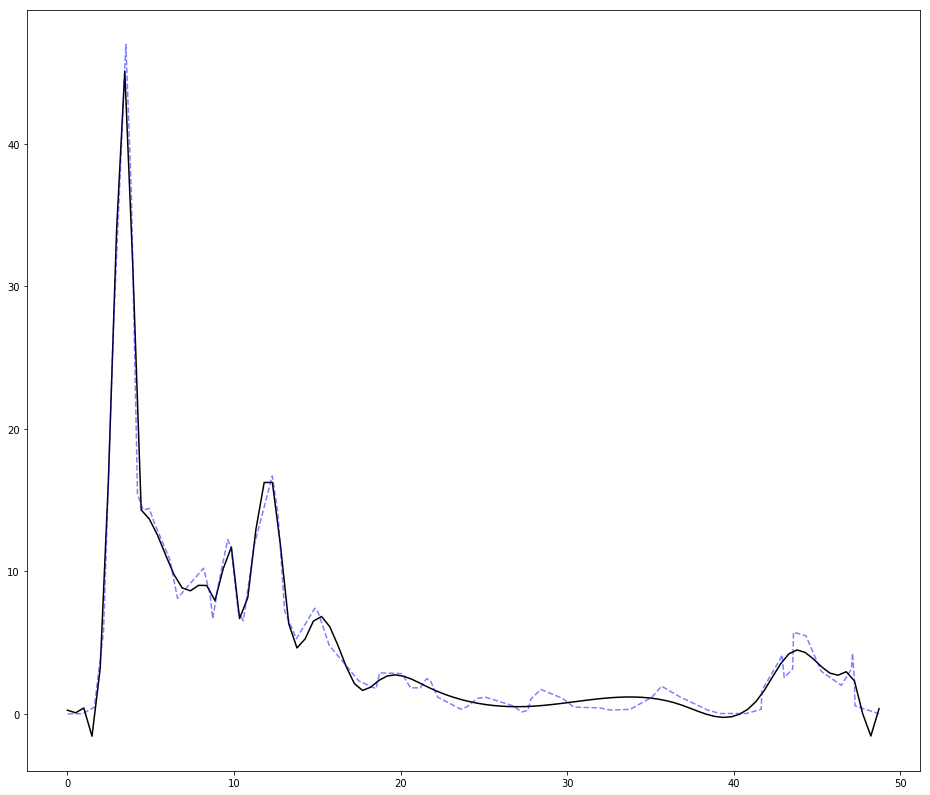

In [156]:
# Splines
field = unit.fields[0]
tck = splrep(field[:,0],field[:,1], k=3, task=0, s=50)
x2 = np.linspace(0,max(field[:,0]),100)
y2 = splev(x2,tck)
plt.figure(figsize=(16,14))
plt.plot(x2,y2,'k')
plt.plot(field[:,0], field[:,1], 'b--', alpha=0.5)

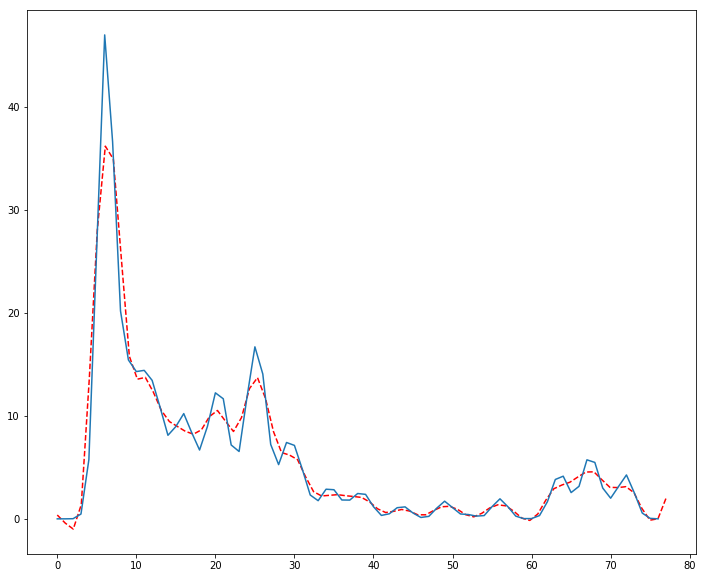

In [154]:
# Savitsky-Golay Filter
# but bc this returns a filtered list, and not a fx we can use to eval,
# use an unsmoothed cubic spline to recreate the S-G filter and use that. 
ysg = savgol_filter(field[:,1], window_length=7, polyorder=3)
tck = splrep(range(len(ysg)), ysg, k=3, task=0)
x = np.linspace(0,len(ysg), len(ysg))
yspl = splev(x, tck)
#plt.plot(x,ysg,'k')
plt.figure(figsize=(12,10))
plt.plot(x,yspl,'r--')
plt.plot(field[:,1])

#### MSE and CV to select best smoothing parameters

In [126]:
propDropOut = .33
nRuns = 100
smoothingValues = np.arange(20,70,10)
field = unit.fields[0]
mses = []

for sm in smoothingValues:
    mses.append([])
    for r in range(nRuns):
        rmIdx = np.random.choice(range(field.shape[0]), int(round(field.shape[0]*propDropOut)), replace=False)
        dsField = np.delete(field, rmIdx, axis=0)
        rmIdx = rmIdx[rmIdx<max(dsField[:,0])] # bc you cant eval outside what you modeled. big weakness need to find soln
        tck = splrep(dsField[:,0], dsField[:,1], k=3, task=0, s=sm)
        mse = np.mean(np.square(field[rmIdx,:1].T - splev(rmIdx,tck)))        
        mses[-1].append(mse)


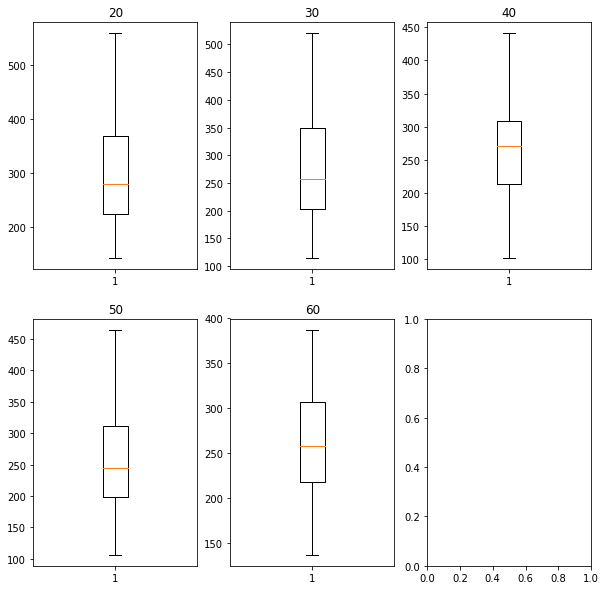

In [155]:
fig, ax = plt.subplots(int(np.ceil(len(smoothingValues)/3)),3, figsize=(10,10))

for i,d in enumerate(mses):
    fig.axes[i].boxplot(d, showfliers=False)
    fig.axes[i].set_title(f"{smoothingValues[i]}")

### Using FFT to get timescales of rate changes 
#### (i.e. low freq components correspond to longer timescale rate changes).

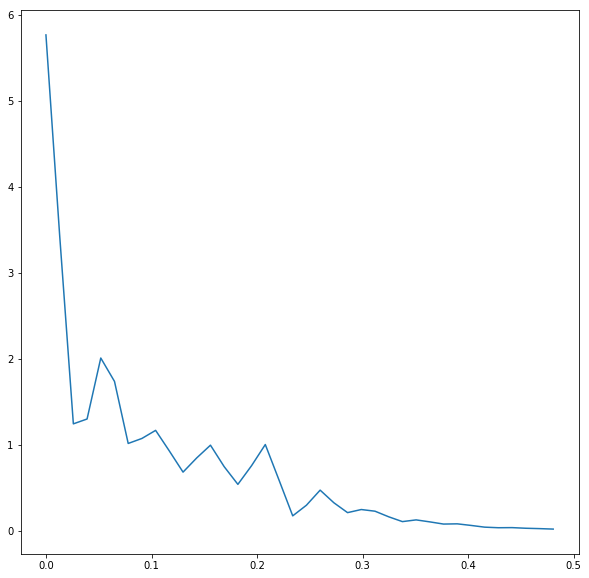

In [196]:
field = unit.fields[0]
%matplotlib inline
plt.figure(figsize=(10,10))
samplingFrequency = 1
samplingInterval = 1/samplingFrequency
fft = np.fft.fft(field[:,1])/field.shape[0]
fft = fft[range(int(field.shape[0]/2))]
tpCount = field.shape[0]
values = np.arange(int(tpCount/2))
timePeriod = tpCount/samplingFrequency
frequencies = values/timePeriod
plt.plot(frequencies, abs(fft))

In [191]:
f, t, Sxx = signal.spectrogram(field[:,1])
plt.figure()
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 77, using nperseg = 77
  .format(nperseg, input_length))


## High-Frequency Rate Changes
### Preprocessing > FFT > Find peaks > bandpass filter 
### Optimal envelope code at the end is for LOW FREQ rate changes, but since
### I'm not probably going to do it that way going forward, call this whole analysis HF

Preprocess unsmoothed or lightly smoothed (sigma=1) signal by 1) windowed mean subtraction and 2) overall mean subtraction  
Then apply FFT and look for peaks above windoweed smoothed FFT signal.  
Bandpass filter original data into these bands +/- some tolerance and find all deflections therein fr.ea. band. This gets you oscillatory based rate changes.  
For nonoscillatory rate changes like ramps, non repeating shifts, etc. Reconstruct the envelope from the Hilbert transform and find deflections on that  
NB that this is all based on visit number being the independent variable, i.e. it's visit num on xaxis not time

In [384]:
# Load Cell
rat = "R859"
day = "D3"
savepath = f'E:\\Ratterdam\\{rat}\\ratterdam_plots\\{day}\\'
df = f'E:\Ratterdam\\{rat}\\{rat}_RatterdamOpen_{day}\\'
clust = "TT6\\cl-maze1.7"
p, s = loadRepeatingUnit(df, clust)
unit = Unit(s,p)

C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\RateMapClass_William_20190308.py:210: RuntimeWarning: invalid value encountered in greater_equal
  aboveThreshold = np.where(rateMap >= max(fieldThreshold,0), True, False)
C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [396]:
# Select Field and analyze
field = unit.fields[0]
#field = np.column_stack((unit.fields[1][:,0], np.random.choice(unit.fields[1][:,1], unit.fields[1].shape[0], replace=False)))
adjustedField = preprocessField(field) # perform 2 mean subtractions. 1 nonoverlapping sliding window, 1 overall mean in that order
X, f = FFT(adjustedField) # fft of this adjusted field. X is fft output f is freqs
filteredSignals, extrema = extractFreqBands(X, f, field) # use butterworth bandpass filter to extract signal around fft peaks
#envlIdx, optAUC, extrList = findOptimalEnvelope(field) # use a cost fx of trade off of auc and peaks kept to compute envelope of signal
#shuffs = computeNullAUC(field,n=1000)

# plot mean adjusted data
fig, axis = plt.subplots(2,1)
fig.axes[0].plot(field[:,1])
fig.axes[1].plot(adjustedField)
fig.axes[1].set_xlabel("Visit")
fig.axes[0].set_ylabel("Firing Rate")
fig.axes[1].set_ylabel("Adjusted Rate")
fig.axes[0].set_title("Original Data (slightly smoothed)")
fig.axes[1].set_title("Mean Adjusted Place Field Over Time (visits)")

# plot fft overlaid with peaks
plt.figure()
plt.plot(f,X,'--')
plt.scatter(f[extrema], X[extrema],s=30,c='r',marker='^')
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("FFT results, mean adjusted place field")

# optional - visualize
plt.figure()
for sig in filteredSignals:
    plt.plot(sig)
plt.legend([f"{i}" for i in f[extrema]])
plt.plot(field[:,1],linewidth=2,color='k')
plt.xlabel("Visit")
plt.ylabel("Adjusted Firing Rate")
plt.title("Bandpass signals of Original Field, overlaid with adjusted")

#plot results for each identified freq band for the single field weve been working with 
fig, ax = plt.subplots(3, int(np.ceil(len(filteredSignals)/3)), figsize=(15,15))
for i in range(len(filteredSignals)):
    axis = fig.axes[i]
    axis.plot(filteredSignals[i],'g')
    axis.plot(adjustedField,color='b',alpha=0.5)
    axis.set_xlabel("Visit")
    axis.set_ylabel("Amp")
    axis.set_title(f"{f[extrema[0][i]]}")
plt.suptitle("Bandpass Filtered Signals")

#plots all fit attempts labeled w normed auc and sigmoid of peak num 
# plt.figure()
# for ex in extrList:
#     plt.plot(ex,field[ex,1], linestyle=next(lines))
# plt.plot(field[:,1],linewidth=2,color='k')
#plt.plot(envlIdx,field[envlIdx,1],'k',linewidth=2)

# plt hist of nulls vs real
# plt.figure()
# plt.hist(shuffs,20)
# plt.vlines(optAUC, 0, plt.gca().get_ylim()[1])
# plt.ylabel("Frequency Count")
# plt.xlabel("AUC")
# plt.title("Distribution of Null and Observed Optimal Envelope AUC Diffs")

Text(0.5,0.98,'Bandpass Filtered Signals')

#### Everything below this are setup stuff, run 1x before running the above cell

In [369]:
# setup vars, support fx. Run 1x on kernel start

ls = [':',"-.","--","-"]
lines = itertools.cycle(ls)

def sigmoid(x, shift=7.5):
    return 1/(1+np.exp(-(x-shift)))

from scipy.signal import butter, lfilter
def filter_data(data, low,high, sf=1, order=2):
    # Determine Nyquist frequency
    nyq = sf/2
    # Set bands
    low = low/nyq
    high = high/nyq
    # Calculate coefficients
    b, a = butter(order, [low, high], btype='band')
    # Filter signal
    filtered_data = lfilter(b, a, data)

    return filtered_data


In [370]:
def preprocessField(field):
    """
    Preprocess data for FFT.
    First, perform nonoverlapping sliding window mean subtraction of each point
    Then overall mean subtraction
    Return processed data. This is only to be used with FFT. Subsequent bandpass filtering should be done
    on original data
    """
    windows = np.asarray(list(more_itertools.windowed(field[:,1], n=5,step=5))) # nb stops when it hits the end w full window size
    windows[-1,(field.shape[0]%5):] = [0]*(5-field.shape[0]%5) # windowed fx doest make window smaller as it hits end so there are len(array)%windowsize Nones or something like that. replace w 0s - FIX THIS
    m = np.nanmean(windows,axis=1)
    m = m[:, np.newaxis]
    data = windows - m
    data = np.ndarray.flatten(data)
    data = data[:field.shape[0]] # you zero padded above effectively so remove them
    data = data - np.mean(data) # this second mean subtraction should get rid of intial peak at 0Hz
    return data

In [12]:
# Preprocessing - overlapping sliding window (option B, dont pick A if so)
# parms hardcoded. Bascially if you slide the window by one element at a time, each element takes 'a turn' being the center of an odd-len window. ith pt = i-(n/2)-1 window.
# except fo the (n/2)-1 elements at the beginning and at the end. So for those use the first and last windows respectively. Then use window means to subtract from each point.
# winSz = 3

# field = unit.fields[0]
# windows = np.asarray(list(more_itertools.windowed(field[:,1], n=winSz, step=1)))
# means = np.mean(windows, axis=1)
# meansub = np.zeros((field.shape[0],1))
# meansub[0], meansub[1] = field[0,1]-means[0], field[1,1]-means[0]
# for i in range(2,field.shape[0]-4):
#     meansub[i] = means[i]
# meansub[-1], meansub[-2] = field[-1,1]-means[-1], field[-2,1]-means[-1]

In [371]:
def FFT(data, plot=False):
    """
    Wrapper to run fft. 
    Fs is 1 (this fx is for visit as indep. var)
    nfft is NOT default. It's the next power of 2 of array size.
    plot optional
    Return X - fft result
           f - list of freqs
    """
    Fs = 1.
    nfft = 2**int(np.ceil(np.log2(field.shape[0]))) # n fft points. 
    X = np.fft.fft(data, nfft)
    df = Fs/nfft
    f = np.arange(0, Fs/2, df)
    nF = len(f)
    X = np.abs(X[0:nF])
    if plot:
        plt.figure()
        plt.plot(f,X,'-^')
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.title("FFT results, mean adjusted place field")
    return X, f

In [381]:
def extractFreqBands(X,f, field):
    """
    !! This is meant for visit as indep var, not time

    Find peaks in FFT, use a butterworth filter to extract
    the signals from the original place field data.
    Bandpass is +/- 0.005 "Hz" of peak
    Return - list of bandpass filtered signals
    """
    
    extrema = scipy.signal.argrelmax(X, order=3) # order is how many points on each side of a given point to consider. has physical interpretion based on nfft and max(fs) (given from nyquist)
    peakFreqs = f[extrema]

    halfWin = 0.01 # half size of bandpass filter window. .2 is def
    filteredSignals = []
    for peak in peakFreqs:
        low, high = peak-halfWin, peak+halfWin
        filtData = filter_data(field[:,1], low, high)
        filteredSignals.append(filtData)
    return filteredSignals, extrema

In [373]:
def findOptimalEnvelope(field, plot=False):
    """
    Uses sp.argrelmax to find all peaks that constitute an envelope.
    Peak detection is based on local max so to find optimal size of locale
    loop over a preset large range of sides and try each. Optimal is
    that which balances AUC (data-envelope) vs shifted sigmoid of peaks kept
    Return peak indices
    """
    baseAUC = auc(range(field.shape[0]), field[:,1])
    orders = range(1,30)
    extrList,aucs = [],[]

    for r in orders:
        extr, = scipy.signal.argrelmax(field[:,1], order=r)
        if extr.shape[0] >= 2:
            obsAUCdiff = auc(extr, field[extr,1]) - baseAUC
            aucs.append(obsAUCdiff)
            extrList.append(extr)
    aucs = np.asarray(aucs)
    anorm = (aucs - aucs.min())/(aucs.max()-aucs.min())
    snorm = [sigmoid(i.shape[0]) for i in extrList]
    optimalOrder = orders[np.argmin(np.abs(anorm-snorm))]
    extr, = scipy.signal.argrelmax(field[:,1],order=optimalOrder)
    optAUCdiff = auc(extr, field[extr,1]) - baseAUC
    if plot:
        plt.figure()
        plt.plot(field[:,1],'k')
        plt.plot(extr,field[extr,1],'--b')
    return extr, optAUCdiff, extrList

In [374]:
def computeNullAUC(field,n=1000):
    """
    Use shuffling to see whether observed test statistic parameterizing rate dynamics (here AUC real - envelope) is 
    different from distribution of the same value computed many times from shuffles
    """
    shaucs = []
    for i in range(n):
        shuff = np.column_stack((field[:,0], np.random.choice(field[:,1],field.shape[0],replace=False)))
        _, shauc,_ = findOptimalEnvelope(shuff)
        shaucs.append(shauc)
    return np.asarray(shaucs)

## Low-frequency Rate changes
### Bandpass filter > Downsampled cublic spline interp > Inflection detection > Filters

In [7]:
# Load Cell
rat = "R859"
day = "D3"
savepath = f'E:\\Ratterdam\\{rat}\\ratterdam_plots\\{day}\\'
df = f'E:\Ratterdam\\{rat}\\{rat}_RatterdamOpen_{day}\\'
clust = "TT1_0001\\cl-maze1.1"
p, s = loadRepeatingUnit(df, clust)
unit = Unit(s,p)

C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\RateMapClass_William_20190308.py:210: RuntimeWarning: invalid value encountered in greater_equal
  aboveThreshold = np.where(rateMap >= max(fieldThreshold,0), True, False)
C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
from scipy.signal import butter, lfilter
def filter_data(data, low,high, sf=1, order=2):
    # Determine Nyquist frequency
    nyq = sf/2
    # Set bands
    low = low/nyq
    high = high/nyq
    # Calculate coefficients
    b, a = butter(order, [low, high], btype='band')
    # Filter signal
    filtered_data = lfilter(b, a, data)

    return filtered_data

In [149]:
def splineFit(data,ds=0.33,s=50):
    """
    !! This is for visit as indp var NOT time
    Generate a downsampled cubic spline interpolation of input data.
    Data should be (n,1) array of FR of visit
    Spline fit is downsampled by proportion ds
    and smoothed by factor s (s is a complicated tradeoff between
    fit and smoothness, higher means more smooth. see scipy splrep doc
    Returns downsampled interpolated array
            and array of x values at which fx was taken, so you can go back to original data coords
    """
    tck = splrep(range(data.shape[0]),data, k=3, task=0, s=s)
    x = np.linspace(0,data.shape[0]-1,np.floor((data.shape[0]-1)*ds))
    y = splev(x,tck)
    return y, x

In [77]:
def findInflections(field):
    """
    Find all inflection pts of the input 1d (n,1) array
    array ([x,y]...)
    I.e. where there is a change in 2nd deriv
    """
    signdelta = np.sign(np.diff(field, axis=0))
    idx = np.where(np.diff(signdelta,axis=0)!=0)[0] # by convention sign returns +/-1 so if you think about it two diff values will be +/2 and two same values in a row will be zero
    idx = idx + 1 # the above catches the point right before the inflection
    idx = np.hstack((0,idx, field.shape[0]-1))
    return idx

def length_filter(idx,data,thresh=2):
    """Filter the visits that have been flagged as rate change
    epoch boundaries by whether the epoch is long enough. Ie. if
    there are at least thresh visits *between* the successive epoch
    bounds
    
    NB these are psuedovisits bc the data has been downsampled
    from the cubic spline interpolation. real number is thresh*(realdatasize/downsamplesize)
    """
    
    #unpacking below: you diff your input idx list and look for diffs that are big enough
    # bc diffing the last element is impossible only get original idx vals up to not incl the end
    passidx = idx[:-1][np.diff(idx,axis=0)>=thresh+1]
    passidx = np.hstack((passidx, data.shape[0]-1)) #add this back on
    passidx = passidx[:,np.newaxis]
    return passidx

def magnitude_filter(idx,data, thresh=0.20):
    """
    Filter potential epochs according to whether or not
    the beginning to end difference (idx[n],idx[n+1]) exceeds
    thresh % of the range of all the data. Data is 1d (n,1) array
    """
    passidx = np.empty((0,1),dtype=np.int)
    for i in range(0,idx.shape[0]-1):
        start, stop = data[idx[i]], data[idx[i+1]]
        pctRange = abs(start-stop)/(data.max()-data.min())
        if pctRange >= thresh:
            passidx = np.vstack((passidx, i))
    passidx = np.vstack((idx[passidx], data.shape[0]-1)) #add this back on 
    return passidx

In [323]:
# Routine to identify low-frequency rate change dynamics

# Preprocess data by removing low
field = unit.fields[2]
#sh = np.random.choice(field[:,1], field.shape[0], replace=False)
#field = np.column_stack((list(range(sh.shape[0])), sh))
hpThresh = 0.05 # this corresponds to a period of twenty visits
highpass = filter_data(field[:,1], hpThresh, 0.49) # with Fs 1, highest freq is 0.5 but cant use that endpoint apparantly in alg
fieldlowpass = field[:,1] - highpass
y,x = splineFit(fieldlowpass,ds=0.33, s=2) # characteristic s mag if you lowpass filter should be 1e0, if you dont 1e1. e.g., 5 vs 50. why? 

# Identify and filter rate regime transitions
# Do magnitude filter first. the raw 2nd deriv deflections give you too many and there are many ways to 
# start to remove them. The magnitude filter removes a lot of these junk epochs and makes it easier going forward.
idx = findInflections(y)
m = magnitude_filter(idx, y, thresh=0.2)
l = length_filter(m, y, thresh=2)

#plot
plt.figure()
plt.plot(field[:,1], color='blue', marker='^')
plt.vlines(x[l],0,field[:,1].max(), 'k')

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]


In [298]:
def rateEpochDetection_lowFrequency(field, plot=True):
    """
    Implements algorithm to take a place field and find slowly changing epochs of firing rate.
    
    Input: (n,1) array of FR
    Returns: x-values of each epoch boundary
    
    Algorithm preprocesses by subtracting high frequency components and interpolating w cublic spline
    Then finds all 2nd deriv changes and filters an epoch by its length and magntitude rate change.
    
    """
    hpThresh = 0.05 # this corresponds to a period of twenty visits
    highpass = filter_data(field, hpThresh, 0.49) # with Fs 1, highest freq is 0.5 but cant use that endpoint apparantly in alg
    fieldlowpass = field - highpass
    y,x = splineFit(fieldlowpass,ds=0.33, s=2) # characteristic s mag if you lowpass filter should be 1e0, if you dont 1e1. e.g., 5 vs 50. why? 

    # Identify and filter rate regime transitions
    # Do magnitude filter first. the raw 2nd deriv deflections give you too many and there are many ways to 
    # start to remove them. The magnitude filter removes a lot of these junk epochs and makes it easier going forward.
    idx = findInflections(y)
    m = magnitude_filter(idx, y, thresh=0.2)
    l = length_filter(m, y, thresh=2)

    #plot
    if plot:
        plt.figure()
        plt.plot(field, color='blue', marker='^')
        plt.vlines(x[l],0,field.max(), 'k')
        plt.title("Field Dynamics Over Time")
        plt.legend(["Firing rate","Epoch Bounds"])
        plt.ylabel("Firing Rate")
        plt.xlabel("Visits")
    
    return l

In [217]:
# Compute two test statistics to quantify rate regimes: Want to capture the magnitude of the changes and thier persistance
# First pass: 1. compute epoch to epoch % change and take average. 2. compute 'reliability' of epoch as assessed by std(diff(rates)) 
data = field[:,1]
# Epoch-to-Epoch magnitude change
avgs = []
for i in range(l.shape[0]-1):
    epoch = data[l[i][0]:l[i+1][0]]
    avgs.append(np.mean(epoch))
avgPctDelta = np.mean([np.abs(a2-a1)/a1 for a1, a2 in zip(avgs, avgs[1:])])

# Standard deviation of the element wise differences in each epoch. Average across epochs. Measure of 'reliability' or 'jumpiness' of signal
scores = []
for i in range(l.shape[0]-1):
    epoch = data[l[i][0]:l[i+1][0]]
    scores.append(np.std(np.diff(epoch)))
score = np.mean(scores)

In [320]:
def computeFieldDynamicsScore(data,l):
    """
    Input: - (n,1) array of firing rates across visits
           - array of epoch boundaries (n,1)
    Output: - A score, B score
    
    A score - average epoch-to-epoch % FR change (abs.)
    B score - average epochwise of std of elementwise diffs within epoch
    """
    # Epoch-to-Epoch magnitude change
    avgs = []
    for i in range(l.shape[0]-1):
        epoch = data[l[i][0]:l[i+1][0]]
        avgs.append(np.mean(epoch))
    avgPctDelta = np.mean([np.abs(a2-a1)/a1 for a1, a2 in zip(avgs, avgs[1:])])

    # Standard deviation of the element wise differences in each epoch. Average across epochs. Measure of 'reliability' or 'jumpiness' of signal
    scores = []
    for i in range(l.shape[0]-1):
        epoch = data[l[i][0]:l[i+1][0]]
        scores.append(np.std(np.diff(epoch)))
    score = np.mean(scores)
    
    return avgPctDelta, score

In [321]:
# Routine - find real rate epoch bounds. Calc test stats. Compare to null dist
field = unit.fields[0]
l = rateEpochDetection_lowFrequency(field[:,1], plot=True)
rmag,rscore = computeFieldDynamicsScore(field[:,1],l)

mags, rels = [], []
for i in range(1000):
    sh = np.random.choice(field[:,1], field.shape[0], replace=False)
    l = rateEpochDetection_lowFrequency(sh, plot=False)
    mag, score = computeFieldDynamicsScore(sh,l)
    mags.append(mag)
    rels.append(score)
mags = np.asarray(mags)
rels = np.asarray(rels)
mags = mags[~np.isnan(mags)]
rels = rels[~np.isnan(rels)]

fig, ax = plt.subplots(2,1,figsize=(6,8))
fig.axes[0].hist(mags,bins=100)
fig.axes[0].vlines(rmag,0,fig.axes[0].get_ylim()[1],color='red')
fig.axes[0].vlines(np.percentile(mags,95), 0, fig.axes[0].get_ylim()[1],color='k')
fig.axes[0].legend(["Real Value", "95% Nulls", "Null Dist"])
fig.axes[0].set_title("Average Pct Change Between Successive Epochs")
fig.axes[0].set_ylabel("Frequency Count")

fig.axes[1].hist(rels,bins=20)
fig.axes[1].vlines(rscore, 0, fig.axes[1].get_ylim()[1], color='r')
fig.axes[1].vlines(np.percentile(rels,5), 0, fig.axes[1].get_ylim()[1],color='k')
fig.axes[1].legend(["Real Value", "95% Nulls", "Null Dist"])
fig.axes[1].set_title("Average 'Jumpiness' of Epochs")
fig.axes[1].set_xlabel("Observation Value")

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,0,'Observation Value')

## Inter-Field Relationships: How field dynamics interact over time. 
## Specific focus on anticorrelation/antiphase behavior

In [271]:
# Load Cell
rat = "R781"
day = "D4"
savepath = f'E:\\Ratterdam\\{rat}\\ratterdam_plots\\{day}\\'
df = f'E:\Ratterdam\\{rat}\\{rat}_RatterdamOpen_{day}\\'
clust = "TT3\\cl-maze1.2"
p, s = loadRepeatingUnit(df, clust)
unit = Unit(s,p)

0.22329706171812355
0.027714925684720036
0.13990169102345842
0.03686274291110565
0.07733464458647088
0.18604204447224296
0.035234694624399224
0.013695324087133403
0.005635918788467607


C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\RateMapClass_William_20190308.py:210: RuntimeWarning: invalid value encountered in greater_equal
  aboveThreshold = np.where(rateMap >= max(fieldThreshold,0), True, False)
C:\Users\whockei1\AppData\Roaming\Python\Python36\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\whockei1\AppData\Roaming\Python\Python36\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\whockei1\AppData\Roaming\Python\Python36\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Functio

### Spline fitting (and checks/viewing of overfitting)

In [282]:
# For each field, get the spline params so two fields can be interpolated to same # pts within a window, allowing for a pearson R calc
fieldFx = [splrep(d[:,0], d[:,1], k=3, task=0, s=5) for d in unit.fields]

In [283]:
fmax = int(np.ceil(max([max(field[:,0]) for field in unit.fields])))

wnSize=5
wnStep = 2
wins = []
for i in range(fmax):
    a,b = 0+(i*wnStep), wnSize+(i*wnStep)
    if b < np.ceil(fmax):
        wins.append((a,b))

In [284]:
## sample spline fx in wins as would be done in analysis and view
nf = len(unit.fields)
xs, ys = [], []
for j in range(nf):
    xc, yc = [], []
    for w in wins:
        start, end = w
        x = np.linspace(start, end, 100)
        interp= splev(x, fieldFx[j])
        xc.append(x)
        yc.append(interp)
    xs.append(xc)
    ys.append(yc)
for i in range(nf):
    xs[i] = [item for sublist in xs[i] for item in sublist]
    ys[i] = [item for sublist in ys[i] for item in sublist]
    
plt.figure()
for i,c in zip(range(nf),['b','r','g','k']):
    plt.plot(xs[i], ys[i],'.',color=c,markersize=4)
    plt.plot(unit.fields[i][:,0], unit.fields[i][:,1], color=c)

In [176]:
start, end = wins[0][0], wins[-1][0]
xs,ys = [],[]
nf = len(unit.fields)
for j in range(nf):
    x = np.linspace(start,end,100*len(wins))
    y = splev(x, fieldFx[j])
    xs.append(x)
    ys.append(y)
    
plt.figure()
for i,c in zip(range(nf),['b','r','g','k']):
    plt.plot(xs[i], ys[i],'.',color=c,markersize=4)
    plt.plot(unit.fields[i][:,0], unit.fields[i][:,1], color=c)

### Running Pairwise Rate Dynamics Analysis

In [289]:
fmax = int(np.ceil(max([max(field[:,0]) for field in unit.fields])))
fmaX=52
wnSize=5
wnStep = 2
wins = []
for i in range(0,fmax):
    a,b = 0+(i*wnStep), wnSize+(i*wnStep)
    if b < np.ceil(fmax):
        wins.append((a,b))

In [290]:
nf = len(unit.fields)
pairs = [f"{i[0]}{i[1]}" for i in list(itertools.product(range(nf),range(nf)))]
corrmats = []
diffmats = []
for w in wins:
    start, end = w
    corrmat = np.zeros((nf,nf))
    diffmat = np.zeros((nf,nf))
    for i in range(nf):
        for j in range(nf):
            x = np.linspace(start, end, 100)
            ainterp, binterp = splev(x,fieldFx[i]), splev(x, fieldFx[j])
            r = scipy.stats.pearsonr(ainterp, binterp)[0]
            diff = np.abs(np.mean(ainterp)-np.mean(binterp))
            corrmat[i,j] = r
            diffmat[i,j] = diff
    corrmats.append(corrmat)
    diffmats.append(diffmat)

In [293]:
# Difference matrices
ncol=10
fig, ax = plt.subplots(int(np.ceil(len(corrmats)/ncol)),ncol,figsize=(8,8))
_max, _min = max([arr.max() for arr in diffmats]), min([arr.min() for arr in diffmats])
for i in range(len(diffmats)):
    im = fig.axes[i].imshow(diffmats[i], aspect='auto',interpolation='None', cmap=cmap, vmin=_min, vmax=_max)
    fig.axes[i].set_title(f"Mins {wins[i][0]}-{wins[i][1]}")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
for i in range(len(fig.axes)):
    fig.axes[i].set_xticks([])
    fig.axes[i].set_yticks([])
plt.suptitle("Time Varying Unsigned Mean Difference Matrices", fontsize=20)
  
# Correlation Matrices
ncol=10
fig, ax = plt.subplots(int(np.ceil(len(corrmats)/ncol)),ncol,figsize=(8,8))
for i in range(len(corrmats)):
    im = fig.axes[i].imshow(corrmats[i], aspect='auto',interpolation='None', cmap='seismic', vmin=-1, vmax=1)
    fig.axes[i].set_title(f"Mins {wins[i][0]}-{wins[i][1]}")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
for i in range(len(fig.axes)):
    fig.axes[i].set_xticks([])
    fig.axes[i].set_yticks([])
plt.suptitle("Time Varying Correlation Matrices", fontsize=20)
    
#plotRoutine_RepPF_TempDyn(0)

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


Text(0.5,0.98,'Time Varying Correlation Matrices')

In [292]:
corrOfcorrs = np.empty((len(diffmats),len(diffmats)))

for i in range(len(diffmats)):
    for j in range(len(diffmats)):
        corrOfcorrs[i,j] = scipy.stats.pearsonr(diffmats[i].flatten(),diffmats[j].flatten())[0]
        
plt.figure()
plt.imshow(corrOfcorrs, origin='lower', interpolation='None')
plt.title("Autocorrelation Matrix of Difference Matrices",fontsize=22)
plt.xlabel("Difference matrices",fontsize=16)
plt.ylabel("Difference matrices", fontsize=16)

Text(0,0.5,'Difference matrices')

In [410]:
with open(df+"sessionEpochInfo.txt","r") as f:
        lines = f.readlines()
startSession_us, endSession_us = int(lines[0].split(',')[0]), int(lines[0].split(',')[1])

startSession = 0 # because were dealing with relative mins in session, its by def 0
endSession = ((endSession_us-startSession_us)/1e6)/60

numShuffles=1000
fig, ax = plt.subplots(2,1, figsize=(10,10))
fd,maxd = compute_max_fieldRateDistances(unit, shuffle=False)
shuffmaxes = []
for i in range(numShuffles):
    _,shuffmax = compute_max_fieldRateDistances(unit, shuffle=True)
    shuffmaxes.append(shuffmax)
shuffmaxes = np.asarray(shuffmaxes)
fig.axes[0].plot(maxd,'r')
pct95 = np.percentile(shuffmaxes,95,axis=0)
fig.axes[0].plot(pct95,'k--')
fig.axes[0].set_xlabel("Time (mins, windowed)")
fig.axes[0].set_ylabel("Composite Maximum FR Diff, Windowed",fontsize=12)

fig.axes[1].imshow(fd, aspect='auto', interpolation='None',cmap=cmap)
fig.axes[1].set_xlabel("Time (min, windowed)")
fig.axes[1].set_ylabel("Pairwise Field Rate Comparisons",fontsize=12)

plt.suptitle("Pairwise Subfield Rate Diffs, Unsigned + Windowed",fontsize=16)

C:\Users\whockei1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Text(0.5,0.98,'Pairwise Subfield Rate Diffs, Unsigned + Windowed')

In [488]:
import matplotlib.animation as animation


wnSize=60*1e6*5
wnStep = 10*1e6

ims = []
start = startSession_us
finished = False

while finished is False:
    end = start + wnSize
    spikes = unit.spikes[np.logical_and(unit.spikes[:,0]>start, unit.spikes[:,0]<=end)]
    pos = unit.position[np.logical_and(unit.position[:,0]>start, unit.position[:,0]<=end)]
    rm = util.makeRM(spikes, pos)
    rm = util.weird_smooth(rm,0.25)
    plt.imshow(rm, aspect='auto', interpolation='None',origin='lower',cmap=cmap,vmin=0,vmax=20)
    plt.pause(0.005)
    plt.clf()
    start = start + wnStep
    if end > endSession_us:
        finished = True 

C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:498: RuntimeWarning: divide by zero encountered in reciprocal
  n = (hs*np.reciprocal(ho))*30
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:498: RuntimeWarning: invalid value encountered in multiply
  n = (hs*np.reciprocal(ho))*30
C:\Users\whockei1\Google Drive\KnierimLab\Ratterdam\Code\utility_fx.py:325: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


### Test Significance of Pairwise Rate Differences: Shuffle

In [24]:
start, end = wins[0][0], wins[-1][0]
xs,ys = [],[]
nf = len(unit.fields)
for j in range(nf):
    x = np.linspace(start,end,100*len(wins))
    y = splev(x, fieldFx[j])
    xs.append(x)
    ys.append(y)

nf = len(unit.fields)
pairs = [f"{i[0]}{i[1]}" for i in list(itertools.combinations(range(nf),2))]
nS = 1000
adjP = (0.05/2)/nf # two sided Bf corrected pvalue
realdiffs = {i:[] for i in pairs}
alldiffs = {i:[] for i in pairs}
for pair in pairs:
    realdiffs[pair] = np.abs(ys[int(pair[0])]-ys[int(pair[1])])
    for n in range(nS):
        a = np.random.permutation(ys[int(pair[0])])
        b = np.random.permutation(ys[int(pair[1])])
        diff = np.abs(a-b)
        alldiffs[pair].append(diff)

In [25]:
fig, ax = plt.subplots(2,3)
for i in range(len(pairs)):
    plow = np.percentile(alldiffs[pairs[i]],0.7,axis=0)
    phigh = np.percentile(alldiffs[pairs[i]],99.3,axis=0)
    fig.axes[i].plot(realdiffs[pairs[i]],c='k')
    fig.axes[i].plot(plow, 'r')
    fig.axes[i].plot(phigh,'r')

### Testing Significance of banding seen in correlation of pairwise difference matrices

In [129]:
corrofmats = np.empty((len(diffmats),len(diffmats)))

for i in range(len(diffmats)):
    for j in range(len(diffmats)):
        corrofmats[i,j] = scipy.stats.pearsonr(diffmats[i].flatten(),diffmats[j].flatten())[0]
        
plt.figure()
plt.imshow(corrofmats, origin='lower', interpolation='None')

In [112]:
# compute a test statistic
corrstats = []
for i in range(len(diffmats)):
    corrstat = np.mean(corrofmats[i,i:]) # this runs along diag and takes one side of the diag matrix. think: when i is five you go to 5,5 and take 5: 
    corrstats.append(corrstat)
realcorr = np.mean(corrstats)

In [126]:
# shuff
n = 1000
allshuffcorrstats = []

for rep in range(n):
    
    shuffcorrofmats = np.zeros((len(diffmats),len(diffmats)))
    order = np.random.choice(range(len(diffmats)),len(diffmats),replace=False)
    for _i,i in enumerate(order):
        for _j,j in enumerate(order):
            shuffcorrofmats[_i,_j] = scipy.stats.pearsonr(diffmats[i].flatten(),diffmats[j].flatten())[0]

    shuffcorrstats = []
    for i in range(len(diffmats)):
        corrstat = np.mean(shuffcorrofmats[i,i:]) # this runs along diag and takes one side of the diag matrix. think: when i is five you go to 5,5 and take 5: 
        shuffcorrstats.append(corrstat)
        
    allshuffcorrstats.append(np.mean(shuffcorrstats))



In [128]:
plt.figure()
plt.imshow(shuffcorrofmats, origin='lower', interpolation='None')